# Set Up

In [1]:
#load packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import ttest_rel
import numpy as np

In [2]:
#set paths
current_directory = os.getcwd()
base_dir = f'{os.path.dirname(current_directory)}/'
data_dir = f'{base_dir}Source_Data/'
fig_dir = f'{base_dir}/figures/'

In [3]:
# set color palettes and variable order
ses_palette = {
    'ses-1': '#440154',
    'ses-2': '#414487', 
    'ses-3': '#2a788e',
    'ses-4': '#22a884',
    'ses-5': '#7ad151'}

dysGroup_palette = {
    'dyslexic': '#8E44AD',
    'typical': '#BB8FCE'}

subGroup_palette = {
    'intervention': '#CD5C5C',
    'dyslexic control': '#D8BFD8',
    'typical control': '#ADD8E6'
}

# set session order
sessions = ['ses-1','ses-2','ses-3','ses-4','ses-5']

# set roi order
rois = ['VWFA1','VWFA2','FFA1','FFA2']
categories = ['T','FF','O','F','L']

# Baseline Differences

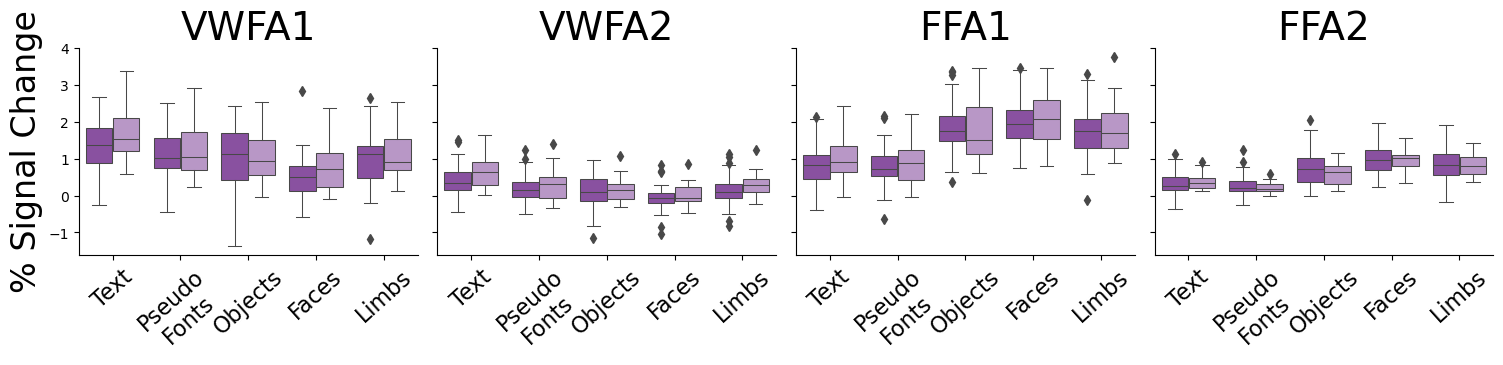

In [4]:
save_fig = False

plot_df = pd.read_csv(f'{data_dir}fig_2e.csv')

# Create the catplot with increased height and adjusted subplot parameters
g = sns.catplot(data=plot_df, x='category', y='mean_psc', errorbar=('se', 1), order = categories,
                col='roi', hue='dysGroups', hue_order=['dyslexic','typical'], kind='box', estimator=np.mean, linewidth=.75, #edgecolor="black",
                palette=list(dysGroup_palette.values()), dodge=True, height=3, aspect=1.25)

# Set axis labels and titles with title casing for col names
g.set_axis_labels('', '% Signal Change', size=24)
g.set_titles(col_template='{col_name}',  size=28)

# Custom X-axis labels
new_labels = ['Text', 'Pseudo\nFonts', 'Objects', 'Faces', 'Limbs']
for ax in g.axes.flatten():
    ax.set_xticklabels(new_labels,size=16,rotation=42)

g._legend.remove()

# Save the figure if needed
if save_fig:
    g.savefig(f'{fig_dir}fig_2e.svg', bbox_inches="tight", transparent=True, dpi=400)

plt.show()


# Longitudinal

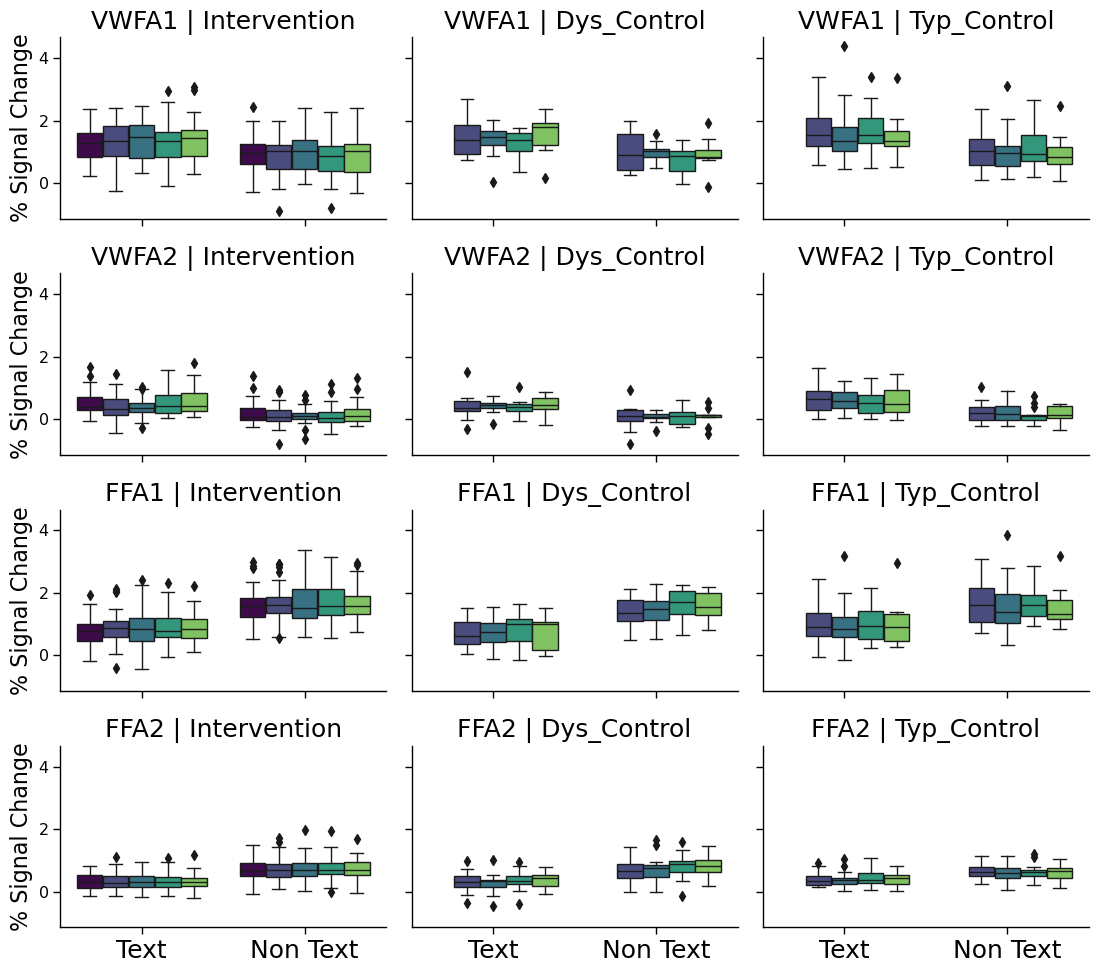

In [8]:
save_fig = False

# load data
plot_df = pd.read_csv(f'{data_dir}fig_5a.csv')

# order variables
subgroup_order = ['intervention', 'dys_control', 'typ_control']
plot_df['study_group'] = pd.Categorical(plot_df['study_group'], categories=subgroup_order, ordered=True)

# set plotting theme
sns.set_theme(context='paper', style=None, font_scale=1.3)

# Create the catplot with increased height and adjusted subplot parameters
g = sns.catplot(data=plot_df, x='category', y='mean_psc', 
                hue='ses', hue_order=sessions, errorbar=('se', 1), 
                col='study_group', row='roi', kind='box', linewidth=1,
                palette=list(ses_palette.values()), dodge=True, height=2.5, aspect=1.5)


# Set axis labels and titles with title casing for col names
g.set_axis_labels('', '% Signal Change', size=16)
g.set_titles(col_template='{col_name}', row_template='{row_name}', size=18)

# Apply title casing to col and row names
for ax in g.axes.flatten():
    col_name = ax.get_title().split('|')[-1].strip()
    row_name = ax.get_title().split('|')[0].strip()
    ax.set_title(f'{row_name} | {col_name.title()}', size=18)

#Custom X-axis labels
new_labels = ['Text', "Non Text"]
for ax in g.axes.flatten():
    ax.set_xticklabels(new_labels,size=18)

# Adjust the space between rows
plt.subplots_adjust(hspace=0.3)

g._legend.remove()

# Save the figure if needed
if save_fig:
    g.savefig(f'{fig_dir}fig_5a.svg', bbox_inches="tight", transparent=True, dpi=400)

plt.show()


### post hoc t test on intervention group to look at change in text and object psc 

In [10]:
 #load data
df = pd.read_csv(f'{data_dir}post-hoc_activations.csv')

# Preparing to store results
results = []

# Loop through each unique roi and category
for roi in df['roi'].unique():
    for category in df['category'].unique():
        # Filter the dataframe for the current roi and category
        filtered_df = df[(df['roi'] == roi) & (df['category'] == category)]
        
        # Pivot the filtered dataframe to separate ses-2 and ses-5
        pivoted_df = filtered_df.pivot(index='sub', columns='ses', values='mean_psc')

        # Check if both ses-2 and ses-5 are present for the subjects
        if 'ses-2' in pivoted_df and 'ses-5' in pivoted_df:
            ses2_data = pivoted_df['ses-2'].dropna()  # drop NaN for ses-2
            ses5_data = pivoted_df['ses-5'].dropna()  # drop NaN for ses-5
            
            # Find the intersection of subjects with data from both sessions
            common_subjects = ses2_data.index.intersection(ses5_data.index)

            # Extract the paired data
            ses2_paired = ses2_data[common_subjects]
            ses5_paired = ses5_data[common_subjects]

            # Run paired samples t-test if there are enough paired subjects
            if len(common_subjects) > 1:
                t_stat, p_value = ttest_rel(ses5_paired, ses2_paired)
                results.append({
                    'roi': roi,
                    'category': category,
                    't_statistic': t_stat,
                    'p_value': p_value,
                    'n_pairs': len(common_subjects)
                })
            else:
                results.append({
                    'roi': roi,
                    'category': category,
                    't_statistic': None,
                    'p_value': None,
                    'n_pairs': len(common_subjects)
                })
        else:
            results.append({
                'roi': roi,
                'category': category,
                't_statistic': None,
                'p_value': None,
                'n_pairs': 0
            })

# Create a results DataFrame
results_df = pd.DataFrame(results)
print(results_df)

     roi category  t_statistic   p_value  n_pairs
0  VWFA1        O    -0.495665  0.623229       36
1  VWFA1        T     1.085378  0.285174       36
2  VWFA2        O     2.206210  0.035168       31
3  VWFA2        T     3.144031  0.003739       31
4   FFA1        O    -0.255505  0.799711       39
5   FFA1        T    -1.763047  0.085934       39
6   FFA2        O     0.179179  0.858749       39
7   FFA2        T    -0.488889  0.627730       39
